## Imports

We use the SymPy library to work with mathematical aspects of symbolic provenance polynomials, such as multiplication, addition, substitution, etc.

In [1]:
# !pip install sympy

In [2]:
# PW-explorer
from PW_explorer.load_worlds import load_worlds
from PW_explorer.run_clingo import run_clingo
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization
from PWE_NB_Extension.helper import ASPRules
# Other utilities
from copy import deepcopy
import pandas as pd
import sympy
from functools import reduce

In [3]:
# Graph-Visualization
import networkx as nx
from nxpd import draw
import nxpd
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [4]:
%load_ext PWE_NB_Extension

## Helpers

In [5]:
def simple_3hop_viz(pw_rel_dfs, gv_md, prov=False):
    g = nx.MultiDiGraph()
    
    g.graph['rankdir'] = 'LR'
    hop_edges_color = 'black'
    thop_edges_color = 'blue'
    thop_df_name = 'thop_3' if prov else 'thop_2'
    
    if thop_df_name in pw_rel_dfs:
        for i, row in pw_rel_dfs[thop_df_name].iterrows():
            g.add_edge(row['x1'], row['x2'], color=thop_edges_color, constraint='false')
        for i, row in pw_rel_dfs['hop_3'].iterrows():
            g.add_edge(row['head'], row['tail'], color=hop_edges_color, style='dotted')
    else:
        for i, row in pw_rel_dfs['hop_3'].iterrows():
            g.add_edge(row['head'], row['tail'], color=hop_edges_color, label=row['hop_name'])
    return g

## Provenance Polynomials

#### Consider a database D of named hops:

In [6]:
%%clingo --donot-display_input -lci hop_db_a --donot-run

% schema hop(head, tail, hop_name)
hop(a,a, p).
hop(a,b, q).
hop(b,a, r).
hop(b,c, s).

We can visualize it easily as follows:

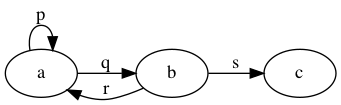

In [7]:
hop_db_a_asp_out, hop_db_a_md = run_clingo(hop_db_a)
hop_db_a_pw_rel_dfs, _, _ = load_worlds(hop_db_a_asp_out, hop_db_a_md, silent=True)
draw(simple_3hop_viz(hop_db_a_pw_rel_dfs, hop_db_a_md['graphviz']))

#### Now consider the traditional 3hop query:

In [8]:
%%clingo --donot-display_input -lci thop_query --donot-run

thop(X,Y) :- hop(X,Z1, P1), hop(Z1,Z2, P2), hop(Z2,Y, P3).

On our hop database D, this yields the following output:

In [9]:
%clingo -l hop_db_a thop_query --donot-display_input -exp thop_D

Output:


'Answer: 1\nhop(a,a,p) hop(a,b,q) hop(b,a,r) hop(b,c,s) thop(a,a) thop(b,a) thop(a,b) thop(b,b) thop(a,c) thop(b,c)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

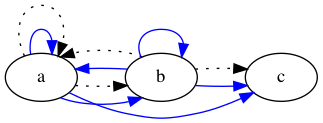

In [10]:
thop_D['pw_rel_dfs'], _, thop_D['pw_objs'] = load_worlds(thop_D['asp_soln'], thop_D['meta_data'], silent=True)
draw(simple_3hop_viz(thop_D['pw_rel_dfs'], thop_D['meta_data']['graphviz']))

As we can see, we get 6 3hop outputs: (a,a), (a,b), (a,c), (b,a), (b,b), (b,c) 

#### Now consider the provenance-enhanced version of the same query:

i.e. we 'record' the hops that build each of the 3hop

In [11]:
%%clingo --donot-display_input --donot-run -lci thop_prov_query

%schema thop(start, dest, prov)
thop(X,Y, f(P1,P2,P3)) :- hop(X,Z1, P1), hop(Z1,Z2, P2), hop(Z2,Y, P3).

Note that the 3hop/2 query is a projection of this query, i.e., we can get the outputs using:

thop(X,Y) :- thop(X,Y,\_).

On running it with our database D, we get the following result:

In [12]:
%clingo -l hop_db_a thop_prov_query --donot-display_input -exp thop_prov_D

Output:


'Answer: 1\nhop(a,a,p) hop(a,b,q) hop(b,a,r) hop(b,c,s) thop(a,a,f(p,p,p)) thop(b,a,f(r,p,p)) thop(a,a,f(q,r,p)) thop(a,b,f(p,p,q)) thop(b,b,f(r,p,q)) thop(a,b,f(q,r,q)) thop(a,a,f(p,q,r)) thop(b,a,f(r,q,r)) thop(a,c,f(p,q,s)) thop(b,c,f(r,q,s))\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

In [13]:
rel = 'thop_3'

thop_prov_D['pw_rel_dfs'], thop_prov_D['rel_schemas'], thop_prov_D['pw_objs'] \
= load_worlds(thop_prov_D['asp_soln'], thop_prov_D['meta_data'], internal_facts_as_string=False)

Number of Models: 1


In [14]:
thop_prov_D['pw_rel_dfs'][rel]

,pw,start,dest,prov
0,1,a,a,"[f, p, p, p]"
1,1,b,a,"[f, r, p, p]"
2,1,a,a,"[f, q, r, p]"
3,1,a,b,"[f, p, p, q]"
4,1,b,b,"[f, r, p, q]"
5,1,a,b,"[f, q, r, q]"
6,1,a,a,"[f, p, q, r]"
7,1,b,a,"[f, r, q, r]"
8,1,a,c,"[f, p, q, s]"
9,1,b,c,"[f, r, q, s]"


In [15]:
thop_prov_D['pw_rel_dfs']['hop_3']

,pw,head,tail,hop_name
0,1,a,a,p
1,1,a,b,q
2,1,b,a,r
3,1,b,c,s


The provenance information captured here (in the 'prov' column) can help us create the __"provenance polynomials"__

In [16]:
# Helper Functions

def prov_mono(row):
    provs = sympy.symbols(row['prov'][1:])
    expr = reduce(lambda x, y: x*y, provs)
    return expr

def list_to_freq_list(l):
    if len(l) <= 0: 
        return []
    l_ = [[l[0],1]]
    for i in range(1, len(l)):
        if l[i] == l_[-1][0]:
            l_[-1][1] += 1
        else:
            l_.append([l[i],1])
    return l_

def prov_mono_ord(row):
    f_list = list_to_freq_list(row['prov'][1:])
    f_list_exprs = list(map(lambda p: '{}^{}'.format(p[0],p[1]) if p[1]>1 else '{}'.format(p[0]), f_list))
    expr = "${}$".format(" ".join(f_list_exprs))
    return expr

First, we create the provenance monomials:

In [17]:
thop_prov_D['pw_rel_dfs'][rel]['prov_mono_ord'] = thop_prov_D['pw_rel_dfs'][rel].apply(prov_mono_ord, axis=1)
thop_prov_D['pw_rel_dfs'][rel]

,pw,start,dest,prov,prov_mono_ord
0,1,a,a,"[f, p, p, p]",$p^3$
1,1,b,a,"[f, r, p, p]",$r p^2$
2,1,a,a,"[f, q, r, p]",$q r p$
3,1,a,b,"[f, p, p, q]",$p^2 q$
4,1,b,b,"[f, r, p, q]",$r p q$
5,1,a,b,"[f, q, r, q]",$q r q$
6,1,a,a,"[f, p, q, r]",$p q r$
7,1,b,a,"[f, r, q, r]",$r q r$
8,1,a,c,"[f, p, q, s]",$p q s$
9,1,b,c,"[f, r, q, s]",$r q s$


Note that the above provenance monomials (prov_mono_ord) are 'ordered' i.e. we preserve the order of the hops that make up the 3hop. In traditional provenance polynomials, order is not preserved, as shown below:

In [18]:
thop_prov_D['pw_rel_dfs'][rel]['prov_mono'] = thop_prov_D['pw_rel_dfs'][rel].apply(prov_mono, axis=1)
thop_prov_D['pw_rel_dfs'][rel]['prov_mono_'] = thop_prov_D['pw_rel_dfs'][rel].apply(lambda row: '${}$'.format(sympy.latex(row['prov_mono'])), axis=1)
thop_prov_D['pw_rel_dfs'][rel][['pw', 'start', 'dest', 'prov', 'prov_mono_ord', 'prov_mono_']]

,pw,start,dest,prov,prov_mono_ord,prov_mono_
0,1,a,a,"[f, p, p, p]",$p^3$,$p^{3}$
1,1,b,a,"[f, r, p, p]",$r p^2$,$p^{2} r$
2,1,a,a,"[f, q, r, p]",$q r p$,$p q r$
3,1,a,b,"[f, p, p, q]",$p^2 q$,$p^{2} q$
4,1,b,b,"[f, r, p, q]",$r p q$,$p q r$
5,1,a,b,"[f, q, r, q]",$q r q$,$q^{2} r$
6,1,a,a,"[f, p, q, r]",$p q r$,$p q r$
7,1,b,a,"[f, r, q, r]",$r q r$,$q r^{2}$
8,1,a,c,"[f, p, q, s]",$p q s$,$p q s$
9,1,b,c,"[f, r, q, s]",$r q s$,$q r s$


Now, we can form the _provenance polynomials_ for each of the 3hop solutions by using a group-by (start-dest pairs) on the monomials and then using a simple summation aggregation function:

In [19]:
thop_prov_D_prov_poly = thop_prov_D['pw_rel_dfs'][rel].groupby(['start', 'dest']).agg(
    prov_poly=('prov_mono', lambda x: '$'+sympy.latex(sum(x))+'$'))
thop_prov_D_prov_poly.style.set_properties(subset=['prov_poly'], **{'width': '100px'})

#### The provenance polynomials can be used for various use-cases.

For instance, say we want to know what happens when we slightly modify the database D, say delete the hop 'p' (i.e. hop(a,a)).

One way to do it would be to modify the database D:

(let's call this modified database Db)

In [20]:
%%clingo --donot-display_input -lci hop_db_b --donot-run

% schema hop(head, tail, hop_name)

% hop(a,a, p). --> DELETE
hop(a,b, q).
hop(b,a, r).
hop(b,c, s).

And re-run the query:

In [21]:
%clingo -l hop_db_b thop_query --donot-display_input -exp thop_Db

Output:


'Answer: 1\nhop(a,b,q) hop(b,a,r) hop(b,c,s) thop(a,b) thop(b,a) thop(b,c)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

As we can see, there are 3 outputs: 3hop(a,b), 3hop(b,a), 3hop(b,c).

Or, we could delete some of the results in Datalog using the previous result, using a procedure like shown below:

In [22]:
%%clingo -lci thop_remove_p --donot-run --donot-display_input

del_thop(X,Y, f(P1,P2,P3)) :- thop(X,Y, f(P1,P2,P3)), P1=p.
del_thop(X,Y, f(P1,P2,P3)) :- thop(X,Y, f(P1,P2,P3)), P2=p. 
del_thop(X,Y, f(P1,P2,P3)) :- thop(X,Y, f(P1,P2,P3)), P3=p.

new_thop(X,Y, F) :- thop(X,Y, F), not del_thop(X,Y, F).
#show new_thop/3.

Here, the thop/3 logical atoms come from materializing our earlier results from trop_prov_D experiments into a database of logical atoms, as shown below:

In [23]:
thop_prov_D_facts = PWEExport.export_as_asp_facts(thop_prov_D['pw_objs'], include_pw_ids=False)
ASPRules(thop_prov_D_facts)

'hop(a,a,p).\nhop(a,b,q).\nhop(b,a,r).\nhop(b,c,s).\nthop(a,a,f(p,p,p)).\nthop(b,a,f(r,p,p)).\nthop(a,a,f(q,r,p)).\nthop(a,b,f(p,p,q)).\nthop(b,b,f(r,p,q)).\nthop(a,b,f(q,r,q)).\nthop(a,a,f(p,q,r)).\nthop(b,a,f(r,q,r)).\nthop(a,c,f(p,q,s)).\nthop(b,c,f(r,q,s)).'

In this way, we don't need to re-run the 3hop query itself, just do further computations on the already available results. 

Now we run the 'thop_remove_p' rules along with the set of logical facts above, to get the desired results:

In [24]:
%clingo -l thop_remove_p thop_prov_D_facts --donot-display_input

Output:


'Answer: 1\nnew_thop(a,b,f(q,r,q)) new_thop(b,a,f(r,q,r)) new_thop(b,c,f(r,q,s))\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

As we can see, this also gives us the same 3 results. However, even this requires re-running some sort of querying the provenance information in Datalog.

#### Using Provenance Polynomials
We can get the desired result without ever re-running the query, by simply substituting p=0 in the provenance monomials and polynomials:

Recall that the provenance monomials on the original database D looked as follows:

In [25]:
thop_prov_D['pw_rel_dfs'][rel][['pw', 'start', 'dest', 'prov_mono_']]

,pw,start,dest,prov_mono_
0,1,a,a,$p^{3}$
1,1,b,a,$p^{2} r$
2,1,a,a,$p q r$
3,1,a,b,$p^{2} q$
4,1,b,b,$p q r$
5,1,a,b,$q^{2} r$
6,1,a,a,$p q r$
7,1,b,a,$q r^{2}$
8,1,a,c,$p q s$
9,1,b,c,$q r s$


Now, we simply substitute p=0 in these provenance monomials:

In [26]:
thop_prov_Db = deepcopy(thop_prov_D)
substitutions = {'p':0}

thop_prov_Db['pw_rel_dfs'][rel]['prov_mono'] \
= thop_prov_Db['pw_rel_dfs'][rel].apply(lambda row: row['prov_mono'].subs(substitutions).evalf(), axis=1)

thop_prov_Db['pw_rel_dfs'][rel]['prov_mono_'] \
= thop_prov_Db['pw_rel_dfs'][rel].apply(lambda row: '${}$'.format(sympy.latex(row['prov_mono'])), axis=1)

thop_prov_Db['pw_rel_dfs'][rel][['pw', 'start', 'dest', 'prov_mono_']]

,pw,start,dest,prov_mono_
0,1,a,a,$0$
1,1,b,a,$0$
2,1,a,a,$0$
3,1,a,b,$0$
4,1,b,b,$0$
5,1,a,b,$q^{2} r$
6,1,a,a,$0$
7,1,b,a,$q r^{2}$
8,1,a,c,$0$
9,1,b,c,$q r s$


And removing the 0 monomials:

In [27]:
drop_cond = thop_prov_Db['pw_rel_dfs'][rel].prov_mono == 0
thop_prov_Db['pw_rel_dfs'][rel].drop(thop_prov_Db['pw_rel_dfs'][rel][drop_cond].index, axis=0, inplace=True)
thop_prov_Db['pw_rel_dfs'][rel][['pw', 'start', 'dest', 'prov_mono_']]

,pw,start,dest,prov_mono_
5,1,a,b,$q^{2} r$
7,1,b,a,$q r^{2}$
9,1,b,c,$q r s$


As we can see, we get the results, along with the correct provenance information, without re-running the query or any other Datalog operation.

Like before, we can compute the provenance polynomials by grouping by the variables in the head (start, dest) and aggregating the provenance monomials by adding them:

In [28]:
thop_prov_Db['pw_rel_dfs'][rel].groupby(['start', 'dest']).agg(prov_poly=('prov_mono', 
                                                          lambda x: '$'+sympy.latex(sum(x))+'$'))

prov_poly
start dest           
a     b     $q^{2} r$
b     a     $q r^{2}$
      c       $q r s$

#### Provenance Polynomials have other interestings uses as well

For instance, say each hop had a corresponding 'work' value, i.e. amount of work required to make the hop.
Then, one might be interested in finding the most/minimum amount of work required for each 3hop/2 (start-dest pair). This can be done using __tropical semirings__ i.e. we treat multiplication as addition and addition as the max/min operator.

In [29]:
%%clingo --donot-display_input -lci hop_db_a_work --donot-run

% schema hop_work(hop_name, work)
hop_work(p, 0).
hop_work(q, 5).
hop_work(r, 10).
hop_work(s, 15).

One way to compute the desired 3hops would be to re-run the entire operation with a Datalog program like the one below:

(say for the min operation)

In [30]:
%%clingo --donot-display_input -l hop_db_a hop_db_a_work

thop(X,Y, WORK) :- hop(X,Z1,P1), hop(Z1,Z2,P2), hop(Z2,Y,P3), 
    hop_work(P1,WP1), hop_work(P2,WP2), hop_work(P3,WP3), WORK=WP1+WP2+WP3.

thop_opt(X,Y, WORK) :- #min{W: thop(X,Y, W)} = WORK, thop(X,Y,_).

#show thop_opt/3.

Output:


'Answer: 1\nthop_opt(a,a,0) thop_opt(a,b,5) thop_opt(a,c,20) thop_opt(b,a,10) thop_opt(b,b,15) thop_opt(b,c,30)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

Note that since we do not have any provenance information, we, for example, know that there exists a sequence of 3 hops that takes 0 work to get from a to a, but we don't know which of the 3 (we know from earlier that there are 3 ways to go from a to a in 3 hops) 3hop(a,a) sequences achieves this.

Or, using the provenance information from earlier, we can do the following:

In [31]:
%%clingo --donot-display_input -l thop_prov_D_facts hop_db_a_work

thop(X,Y, f(P1,P2,P3), WORK) :- thop(X,Y, f(P1,P2,P3)), 
    hop_work(P1,WP1), hop_work(P2,WP2), hop_work(P3,WP3), WORK=WP1+WP2+WP3.

thop_opt(X,Y, WORK) :- #min{W: thop(X,Y, _, W)} = WORK, thop(X,Y,_,_).
thop_opt(X,Y, PROV, WORK) :- thop_opt(X,Y, WORK), thop(X,Y,PROV,WORK).

#show thop_opt/4.

Output:


'Answer: 1\nthop_opt(a,a,f(p,p,p),0) thop_opt(b,a,f(r,p,p),10) thop_opt(a,b,f(p,p,q),5) thop_opt(b,b,f(r,p,q),15) thop_opt(a,c,f(p,q,s),20) thop_opt(b,c,f(r,q,s),30)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

As we can see, the answers match exactly, and we never had to re-evaluate the original 3hop query on the database. In addition, we know the hops that make up this optimized 3hop.

Another way to do this is directly in Python using the provenance monomials as follows:

First, we import the work values for the hops into Python and make a Python dictionary to enable substitution into the provenance monomials.

In [32]:
hop_db_a_work_asp_out, hop_db_a_work_md = run_clingo(hop_db_a_work)
hop_db_a_work_pw_rel_dfs, _, _ = load_worlds(hop_db_a_work_asp_out, hop_db_a_work_md, silent=True)
hop_work_map = {row['hop_name']: int(row['work']) for _, row in hop_db_a_work_pw_rel_dfs['hop_work_2'].iterrows()}
hop_work_map

{'p': 0, 'q': 5, 'r': 10, 's': 15}

In [33]:
def tropical_semiring_mono(row):
    provs = sympy.symbols(row['prov'][1:])
    expr = reduce(lambda x, y: x+y, provs)
    return expr

Now, we can build our tropical semiring expressions:

In [34]:
thop_opt_prov_D = deepcopy(thop_prov_D)

thop_opt_prov_D['pw_rel_dfs'][rel]['prov_trop_mono'] = thop_opt_prov_D['pw_rel_dfs'][rel].apply(tropical_semiring_mono, axis=1)
thop_opt_prov_D['pw_rel_dfs'][rel]['prov_trop_mono_'] = thop_opt_prov_D['pw_rel_dfs'][rel].apply(lambda row: '${}$'.format(sympy.latex(row['prov_trop_mono'])), axis=1)
thop_opt_prov_D['pw_rel_dfs'][rel][['pw', 'start', 'dest', 'prov', 'prov_trop_mono_']]

,pw,start,dest,prov,prov_trop_mono_
0,1,a,a,"[f, p, p, p]",$3 p$
1,1,b,a,"[f, r, p, p]",$2 p + r$
2,1,a,a,"[f, q, r, p]",$p + q + r$
3,1,a,b,"[f, p, p, q]",$2 p + q$
4,1,b,b,"[f, r, p, q]",$p + q + r$
5,1,a,b,"[f, q, r, q]",$2 q + r$
6,1,a,a,"[f, p, q, r]",$p + q + r$
7,1,b,a,"[f, r, q, r]",$q + 2 r$
8,1,a,c,"[f, p, q, s]",$p + q + s$
9,1,b,c,"[f, r, q, s]",$q + r + s$


To get the optimal solutions, we can now aggregate based on the min/max value of the prov_expr_ after grouping by the start-dest pairs:

In [35]:
thop_opt_prov_D_trop_poly = thop_opt_prov_D['pw_rel_dfs'][rel].groupby(['start', 'dest']).agg(
    prov_trop_poly_min=('prov_trop_mono', lambda x: '$'+sympy.latex(sympy.Min(*x))+'$'),
    prov_trop_poly_max=('prov_trop_mono', lambda x: '$'+sympy.latex(sympy.Max(*x))+'$'))

thop_opt_prov_D_trop_poly.style.set_properties(subset=['prov_trop_poly_min', 'prov_trop_poly_max'], **{'width': '150px'})

Now, we can substitute the work values to get the numerical solution:

In [36]:
thop_opt_prov_D['pw_rel_dfs'][rel]['prov_trop_mono'] \
= thop_opt_prov_D['pw_rel_dfs'][rel].apply(lambda row: row['prov_trop_mono'].subs(hop_work_map).evalf(), axis=1)

thop_opt_prov_D['pw_rel_dfs'][rel]['prov_trop_mono_'] \
= thop_opt_prov_D['pw_rel_dfs'][rel].apply(lambda row: '${}$'.format(sympy.latex(row['prov_trop_mono'])), axis=1)

thop_opt_prov_D['pw_rel_dfs'][rel][['pw', 'start', 'dest', 'prov_trop_mono_']]

,pw,start,dest,prov_trop_mono_
0,1,a,a,$0$
1,1,b,a,$10.0$
2,1,a,a,$15.0$
3,1,a,b,$5.0$
4,1,b,b,$15.0$
5,1,a,b,$20.0$
6,1,a,a,$15.0$
7,1,b,a,$25.0$
8,1,a,c,$20.0$
9,1,b,c,$30.0$


In [37]:
thop_opt_prov_D['pw_rel_dfs'][rel].groupby(['start', 'dest']).agg(prov_trop_poly_min=('prov_trop_mono', 
                                                          lambda x: '$'+sympy.latex(min(x))+'$'),
                                                                 prov_trop_poly_max=('prov_trop_mono', 
                                                          lambda x: '$'+sympy.latex(max(x))+'$'))

prov_trop_poly_min prov_trop_poly_max
start dest                                      
a     a                   $0$             $15.0$
      b                 $5.0$             $20.0$
      c                $20.0$             $20.0$
b     a                $10.0$             $25.0$
      b                $15.0$             $15.0$
      c                $30.0$             $30.0$

As we can see, this matches the earlier solutions exactly, and required no further Datalog computation, just pure mathematical substitution and manipulation.

One can repeat the demonstrations above with minor modifications for other variants of the 3hop query such as:

In [38]:
%%clingo --donot-display_input --donot-run

%schema thop(start, prov)
thop(X, f(P1,P2,P3)) :- e(X,Z1, P1), e(Z1,Z2, P2), e(Z2,Y, P3).

#show thop/2.

In [39]:
%%clingo --donot-display_input --donot-run

%schema thop(dest, prov)
thop(Y, f(P1,P2,P3)) :- e(X,Z1, P1), e(Z1,Z2, P2), e(Z2,Y, P3).

#show thop/2.

In [40]:
%%clingo --donot-display_input --donot-run

%schema thop(dest, prov)
thop(Z1, Z2, f(P1,P2,P3)) :- e(X,Z1, P1), e(Z1,Z2, P2), e(Z2,Y, P3).

#show thop/3.

In [41]:
%%clingo --donot-display_input --donot-run

%schema thop(dest, prov)
thop(X, Z1, Z2, Y, f(P1,P2,P3)) :- e(X,Z1, P1), e(Z1,Z2, P2), e(Z2,Y, P3).

#show thop/5.

And so on......

#### However, provenance polynomials do have some limitations.

For instance, since they don't preserve order, one cannot tell, say (p,q,r) from (q,r,p), since they're both reduced to $pqr$.